In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats

# Sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor  # For regression
from sklearn.ensemble import RandomForestClassifier  # For classification
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

# Statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.options.display.float_format = '{:.2f}'.format

In [ ]:
def cleaner(df, unneeded_columns=None, date_columns=None, date_format = None , to_category_columns=None, to_cat_code_columns = None , outlier_columns=None):

    """ This function get pandas DataFrame and attributes like 'date_columns' and 'to_category_columns' to manipulate , clean and prepare dataset for usage """

    # Convert specified columns to datetime
    if date_columns:
        for date_column in date_columns:
            if date_column in df.columns:
                df[date_column] = pd.to_datetime(df[date_column], format = date_format ,errors='coerce')

    # Convert specified columns to category
    if to_category_columns:
        for category_column in to_category_columns:
            if category_column in df.columns:
                df[category_column] = df[category_column].astype('category')

        if to_cat_code_columns:
            for column in to_cat_code_columns:
                df[f'{column}_code'] = df[column].cat.codes

    # Handle outliers using the IQR method
    if outlier_columns:
        for outlier_column in outlier_columns:
            if outlier_column in df.columns:
                iqr = df[outlier_column].quantile(0.75) - df[outlier_column].quantile(0.25)
                lower_bound = df[outlier_column].quantile(0.25) - (1.5 * iqr)
                upper_bound = df[outlier_column].quantile(0.75) + (1.5 * iqr)
                df = df[(df[outlier_column] >= lower_bound) & (df[outlier_column] <= upper_bound)]

     # Drop unnecessary columns
    if unneeded_columns:
        df = df.drop(columns=unneeded_columns)  # Use 'errors="ignore"' to avoid errors if columns don't exist.

    # Rename columns
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('(', '', regex=False)
    df.columns = df.columns.str.replace(')', '', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)
    df.columns = df.columns.str.replace('.', '', regex=False)
    df.columns = df.columns.str.replace('/', '', regex=False)
    df.columns = df.columns.str.replace('\\', '', regex=False)
    df.columns = df.columns.str.replace('%', '_percent', regex=False)

    return df

In [ ]:
def plot_boxplots(df):

    """ This function get as pandas DataFrame to vizualize as boxplot each numeric feature in dataset , which gives basic understanding of distribution """

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Create subplots
    num_cols = len(numeric_cols)
    cols_per_row = 3  # Adjust based on preference
    rows = (num_cols + cols_per_row - 1) // cols_per_row  # Compute rows needed
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Generate boxplots
    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'Boxplot: {col}')

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## IMPORT & EXPLORE

In [ ]:
sticker_sales_train = pd.read_csv(r"C:\Users\User\Downloads\kaggle_sticker_sales_data_competition\train.csv")

sticker_sales_test = pd.read_csv(r"C:\Users\User\Downloads\kaggle_sticker_sales_data_competition\test.csv")


**TRAIN DATA**

In [ ]:
sticker_sales_train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.00
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.00
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.00
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.00


In [ ]:
sticker_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


<Axes: >

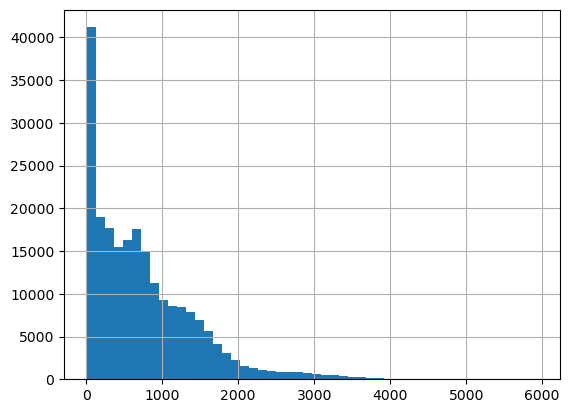

In [ ]:
sticker_sales_train['num_sold'].hist(bins = 50)

**TEST DATA**

In [ ]:
sticker_sales_test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [ ]:
sticker_sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


## CLEAN & PREPARE

#### TRAIN DATA

In [ ]:
# handling missing values

sticker_sales_train['num_sold'] = sticker_sales_train['num_sold'].ffill().fillna(sticker_sales_train['num_sold'].median())


In [ ]:
# use prepared function for cleaning manipulations

sticker_sales_train = cleaner(df = sticker_sales_train,
                              unneeded_columns=['id'],
                              date_columns=['date'],
                              date_format = None ,
                              to_category_columns=['country','store','product'],
                              to_cat_code_columns = ['country','store','product'] ,
                              outlier_columns=['num_sold'])

#### TEST DATA

In [ ]:
# use prepared function for cleaning manipulations

sticker_sales_test = cleaner(df = sticker_sales_test,
                              unneeded_columns=None,
                              date_columns=['date'],
                              date_format = None ,
                              to_category_columns=['country','store','product'],
                              to_cat_code_columns = ['country','store','product'] ,
                              outlier_columns=None)

## MODEL BUILDING

### PREPARE DATA FOR MODEL BUILDING

#### FEATURE EXTRACTION

##### TRAIN DATA

In [ ]:
sticker_sales_train['year'] = sticker_sales_train['date'].dt.year

sticker_sales_train['month_num'] = sticker_sales_train['date'].dt.month

sticker_sales_train['week_num'] = sticker_sales_train['date'].dt.isocalendar().week

sticker_sales_train['day_of_year'] = sticker_sales_train['date'].dt.day_of_year

sticker_sales_train['day_of_month'] = sticker_sales_train['date'].dt.day

sticker_sales_train['weekday'] = sticker_sales_train['date'].dt.weekday

##### TEST DATA

In [ ]:
sticker_sales_test['year'] = sticker_sales_test['date'].dt.year

sticker_sales_test['month_num'] = sticker_sales_test['date'].dt.month

sticker_sales_test['week_num'] = sticker_sales_test['date'].dt.isocalendar().week

sticker_sales_test['day_of_year'] = sticker_sales_test['date'].dt.day_of_year

sticker_sales_test['day_of_month'] = sticker_sales_test['date'].dt.day

sticker_sales_test['weekday'] = sticker_sales_test['date'].dt.weekday

#### DEFINE X and Y

In [ ]:
# define X (independent) and Y (dependent) variables

sticker_sales_independent = sticker_sales_train.select_dtypes(include = ('number')).drop(columns = ['num_sold'])

sticker_sales_dependent = sticker_sales_train['num_sold']

# split data into train and test subsets

sticker_sales_independent_train , sticker_sales_independent_test , sticker_sales_dependent_train , sticker_sales_dependent_test = train_test_split(
    sticker_sales_independent ,
    sticker_sales_dependent ,
    train_size = 0.9 ,
    random_state = 42
)

In [ ]:
print(f'STICKER SALES DATA INDEPENDENT SUBSETS SHAPE (TRAIN-TEST) : {sticker_sales_independent_train.shape ,
                                                                     sticker_sales_independent_test.shape}')

STICKER SALES DATA INDEPENDENT SUBSETS SHAPE (TRAIN-TEST) : ((200793, 9), (22311, 9))


#### HistGradientBoosting

In [ ]:
# define HistGradientBoosting model

sticker_sales_hist_gradient_boosting_regressor = HistGradientBoostingRegressor(max_iter = 500 ,
                                                                               random_state = 42,
                                                                               warm_start = True) # this will make it possible to easier improve model

In [ ]:
# fit the sticker_sales_hist_gradient_boosting_regressor

sticker_sales_hist_gradient_boosting_regressor.fit(sticker_sales_independent_train ,
                                                   sticker_sales_dependent_train)

HistGradientBoostingRegressor(max_iter=500, random_state=42, warm_start=True)

In [ ]:
# get model's predicions and evaluate them

# as we do not have independent_test subset , we could only compare results using inital data

sticker_sales_hist_gradient_boosting_regressor_predictions = sticker_sales_hist_gradient_boosting_regressor.predict(sticker_sales_independent_test)

# evaluate them

print(f'R2 : {metrics.r2_score(sticker_sales_dependent_test ,
                               sticker_sales_hist_gradient_boosting_regressor_predictions)}')

print(f'MAE : {metrics.mean_absolute_error(sticker_sales_dependent_test ,
                                           sticker_sales_hist_gradient_boosting_regressor_predictions)}')

R2 : 0.9917478641591627
MAE : 32.1371128746807


The R2 score we just have is already nice , but let's improve model more using warm_start

In [ ]:
sticker_sales_hist_gradient_boosting_regressor.set_params(max_iter=1000) # increase number of iterations twice

sticker_sales_hist_gradient_boosting_regressor.fit(sticker_sales_independent_train ,
                                                   sticker_sales_dependent_train)

HistGradientBoostingRegressor(max_iter=1000, random_state=42, warm_start=True)

In [ ]:
# get model's predicions and evaluate them

# as we do not have independent_test subset , we could only compare results using inital data

sticker_sales_hist_gradient_boosting_regressor_predictions = sticker_sales_hist_gradient_boosting_regressor.predict(sticker_sales_independent_test)

# evaluate them

print(f'R2 : {metrics.r2_score(sticker_sales_dependent_test ,
                               sticker_sales_hist_gradient_boosting_regressor_predictions)}')

print(f'MAE : {metrics.mean_absolute_error(sticker_sales_dependent_test ,
                                           sticker_sales_hist_gradient_boosting_regressor_predictions)}')

R2 : 0.9923099033025619
MAE : 30.51392014504614


#### GET FINAL - COMPETITIONS PREDICTINOS

In [ ]:
sticker_sales_hist_gradient_boosting_regressor_competition_predictions = sticker_sales_hist_gradient_boosting_regressor.predict(sticker_sales_test.select_dtypes(include = ('number')).drop(columns=['id']))

sticker_sales_test['preedicted_num_sold'] = sticker_sales_hist_gradient_boosting_regressor_competition_predictions

In [ ]:
# handling unrealistic predicted values gently

sticker_sales_test['preedicted_num_sold'] = np.where(sticker_sales_test['preedicted_num_sold'] < 0 ,
                                                     sticker_sales_test['preedicted_num_sold'].quantile(0.25) ,
                                                     sticker_sales_test['preedicted_num_sold'])

In [ ]:
sticker_sales_test.describe()

,id,date,country_code,store_code,product_code,year,month_num,week_num,day_of_year,day_of_month,weekday,preedicted_num_sold
count,98550.00,98550,98550.00,98550.00,98550.00,98550.00,98550.00,98550.00,98550.00,98550.00,98550.00,98550.00
mean,279404.50,2018-07-02 00:00:00,2.50,1.00,2.00,2018.00,6.53,26.48,183.00,15.72,3.00,674.19
min,230130.00,2017-01-01 00:00:00,0.00,0.00,0.00,2017.00,1.00,1.00,1.00,1.00,0.00,0.01
25%,254767.25,2017-10-01 00:00:00,1.00,0.00,1.00,2017.00,4.00,13.00,92.00,8.00,1.00,217.02
50%,279404.50,2018-07-02 00:00:00,2.50,1.00,2.00,2018.00,7.00,26.00,183.00,16.00,3.00,559.28
75%,304041.75,2019-04-02 00:00:00,4.00,2.00,3.00,2019.00,10.00,40.00,274.00,23.00,5.00,1006.44
max,328679.00,2019-12-31 00:00:00,5.00,2.00,4.00,2019.00,12.00,52.00,365.00,31.00,6.00,2966.43
std,28449.08,NaN,1.71,0.82,1.41,0.82,3.45,15.05,105.37,8.80,2.00,566.67


In [ ]:
sticker_sales_competition_predictions = sticker_sales_test[['id','preedicted_num_sold']]

sticker_sales_competition_predictions['preedicted_num_sold'] = np.round(sticker_sales_competition_predictions['preedicted_num_sold'])

C:\Users\User\AppData\Local\Temp\ipykernel_8320\622954621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sticker_sales_competition_predictions['preedicted_num_sold'] = np.round(sticker_sales_competition_predictions['preedicted_num_sold'])


## EXPORT

In [ ]:
sticker_sales_competition_predictions.to_csv('sticker_sales_competition_predictions.csv',index = False)